# Sentiment140
анализ очищенных твиттов

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import roc_curve, auc

Загружаем обработанные твитты

In [2]:
with open('Data/Pos_clean_tweets.csv', 'r') as f:
    positive_tweets = [line.rstrip('\n') for line in f]

In [3]:
with open('Data/Neg_clean_tweets.csv', 'r') as f:
    negative_tweets = [line.rstrip('\n') for line in f]

In [4]:
print len(positive_tweets)
print len(negative_tweets)

503659
550487


Объеденяем списки позитивных и негитивных твиттов в один:

In [5]:
tweets = positive_tweets + negative_tweets
len(tweets)

1054146

Создаем список меток, где 1 - позитивные твитты, 0 - негативные

In [6]:
a = [1 for x in range(len(positive_tweets))]
b = [0 for x in range(len(negative_tweets))]
target = a + b
len(target)

1054146

### TfidfVectorizer

В результате подбора параметров, опримальные оказалисть: ngram_range=(1, 3), max_features=500000

In [16]:
tfidf_vectorizer = TfidfVectorizer(stop_words=None,
                                   ngram_range=(1, 3),
                                   max_features=500000)
tfidf_vectorizer.fit(tweets)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=500000, min_df=1,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [13]:
tfidf = tfidf_vectorizer.transform(tweets)
tfidf

<1054146x500000 sparse matrix of type '<type 'numpy.float64'>'
	with 26136277 stored elements in Compressed Sparse Row format>

## Machine Learning
Разделим наш датасет на тренировочную и тестовую части

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(tfidf, target, test_size=0.25, random_state=1)
print(X_train.shape, X_test.shape)

((790609, 500000), (263537, 500000))


### Naive Bayes with SciKit Learn

In [19]:
modelNB = MultinomialNB()
modelNB.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [20]:
# Predicted outcomes
predicted = modelNB.predict(X_test)

# Actual Expected Outvomes
expected = Y_test

metrics.accuracy_score(expected, predicted)

0.81610551839020706

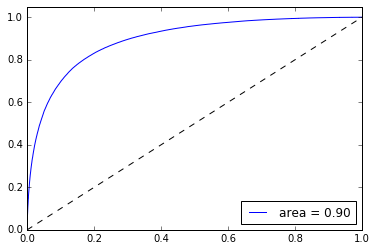

In [21]:
pred_probas = modelNB.predict_proba(X_test)[:,1]
fpr,tpr,roc_thresholds = roc_curve(Y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

### LogisticRegression

In [22]:
modelLR = LogisticRegression()
modelLR.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
# Predicted outcomes
predicted = modelLR.predict(X_test)

# Actual Expected Outvomes
expected = Y_test

metrics.accuracy_score(expected, predicted)

0.83521099504054463

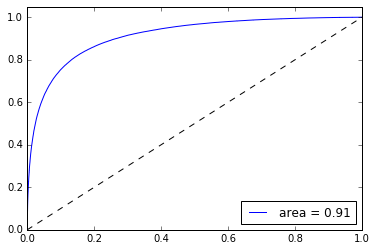

In [24]:
pred_probas = modelLR.predict_proba(X_test)[:,1]
fpr,tpr,roc_thresholds = roc_curve(Y_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

### Test LogisticRegression

In [25]:
example = ['I love this tweet']
X = tfidf_vectorizer.transform(example)
X

<1x500000 sparse matrix of type '<type 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [26]:
p = modelLR.predict_proba(X)[0]
print "Probability:"
print " - Negative: %.2f%%" % (p[0]*100)
print " - Positive: %.2f%%" % (p[1]*100)

Probability:
 - Negative: 0.52%
 - Positive: 99.48%


## Serializing fitted scikit-learn estimators
After we trained the logistic regression model as shown above, we know save the classifier along woth the stop words, Porter Stemmer, and HashingVectorizer as serialized objects to our local disk so that we can use the fitted classifier in our web application later.

In [27]:
import pickle

In [28]:
pickle.dump(modelLR, open('TweetLogisticRegression.pkl', 'wb'), protocol=2)
pickle.dump(tfidf_vectorizer, open('TweetTfidfVectorizer.pkl', 'wb'), protocol=2)

## Test serialized Logistic Regression model

In [1]:
import pickle

In [2]:
modelLR = pickle.load(open('TweetLogisticRegression.pkl', 'rb'))
modelLR

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [3]:
tfidf_vectorizer = pickle.load(open('TweetTfidfVectorizer.pkl', 'rb'))
tfidf_vectorizer

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=500000, min_df=1,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [4]:
example = ['I love this tweet']
X = tfidf_vectorizer.transform(example)

p = modelLR.predict_proba(X)[0]
print "Probability:"
print " - Negative: %.2f%%" % (p[0]*100)
print " - Positive: %.2f%%" % (p[1]*100)

Probability:
 - Negative: 0.52%
 - Positive: 99.48%
